# 주제 : 제주도 교통량 예측 모델 개발 
https://dacon.io/competitions/official/235985/overview/description


#### [배경]
제주도내 주민등록인구는 2022년 기준 약 68만명으로, 연평균 1.3%정도 증가하고 있습니다.    
또한 외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정되며,     
제주도민 증가와 외국인의 증가로 현재 제주도의 교통 체증이 심각한 문제로 떠오르고 있습니다.    
제주도 교통난 해소 대책 마련에 도움이 될 수 있도록 제주도의 교통 정보로부터 도로 교통량을 회귀 예측하는    
'제주도 도로 교통량 예측 AI 알고리즘'을 개발하는 것이 이 프로젝트의 목적입니다.    


#### [설명]    
제주도의 교통 정보로부터 도로 교통량 회귀 예측


#### [주최 / 주관]    
주최: 제주 테크노파크, 제주특별자치도      
주관: 데이콘


#### [평가 산식]    
MAE (평균 절대 오차)


#### [규칙]       
가본 데이터셋이 주어지며, 사용에 법적 제약이 없고 누구나 사용할 수 있는 외부 데이터 추가 사용 가능 (2022년 8월 이전의 데이터만 사용 가능)    
1일 최대 제출 횟수: 3 회

#### 
#### 
#### 1. 데이터 확인

#### Train set
2022년 8월 이전 데이터만 존재하며 날짜, 시간, 교통 및 도로구간 등의 정보와 도로의 차량 평균 속도(Target) 정보 포함 (4,701,217개의 데이터)     
#### Test set
2022년 8월 데이터만 존재하며 날짜, 시간, 교통 및 도로구간 등의 정보 포함 (291,241개의 데이터)  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
import re 
import warnings 
warnings.filterwarnings('ignore')

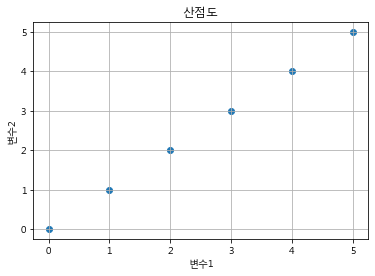

In [2]:
#한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

%matplotlib inline
font_path = "/users/eunji/library/fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
 
plt.scatter([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
plt.title('산점도')
plt.xlabel('변수1')
plt.ylabel('변수2')
plt.grid(True)
plt.show()

In [3]:
# csv to parquet -> 메모리에 효율적인 데이터 유형을 사용하여, 용량을 크게 줄이고 빠른 작업 가능


def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'/users/eunji/desktop/dacon/제주도교통량예측대회/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.') 
    
    
# 데이터를 parquet으로 변환
#!pip install fastparquet
csv_to_parquet('/users/eunji/desktop/open/test.csv' ,'test')
csv_to_parquet('/users/eunji/desktop/open/train.csv' ,'train')


# 데이터 불러오기 
test = pd.read_parquet('/users/eunji/desktop/dacon/제주도교통량예측대회/test.parquet')
train = pd.read_parquet('/users/eunji/desktop/dacon/제주도교통량예측대회/train.parquet')

# 데이터 출처 : 데이콘 https://dacon.io/competitions/official/235985/overview/description


test Done.
train Done.


In [4]:
train.shape, test.shape

((4701217, 24), (291241, 23))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   road_in_use            int64  
 5   lane_count             int64  
 6   road_rating            int64  
 7   road_name              object 
 8   multi_linked           int64  
 9   connect_code           int64  
 10  maximum_speed_limit    float64
 11  vehicle_restricted     float64
 12  weight_restricted      float64
 13  height_restricted      float64
 14  road_type              int64  
 15  start_node_name        object 
 16  start_latitude         float64
 17  start_longitude        float64
 18  start_turn_restricted  object 
 19  end_node_name          object 
 20  end_latitude           float64
 21  end_longitude          float64
 22  end_turn_restricte

In [6]:
# 컬럼 설명 및 데이터 예시

data_info = pd.read_csv('/Users/EUNJI/Desktop/open/data_info.csv')
data_info = data_info.replace({'hight_restricted':'height_restricted'}) 
pd.concat([data_info, train.head().T.loc[data_info['변수명']].reset_index(drop=True)],1)

,변수명,변수 설명,0,1,2,3,4
0,id,아이디,TRAIN_0000000,TRAIN_0000001,TRAIN_0000002,TRAIN_0000003,TRAIN_0000004
1,base_date,날짜,20220623,20220728,20211010,20220311,20211005
2,day_of_week,요일,목,목,일,금,화
3,base_hour,시간대,17,21,7,13,8
4,road_in_use,도로사용여부,0,0,0,0,0
5,lane_count,차로수,1,2,2,2,2
6,road_rating,도로등급,106,103,103,107,103
7,multi_linked,중용구간 여부,0,0,0,0,0
8,connect_code,연결로 코드,0,0,0,0,0
9,maximum_speed_limit,최고속도제한,60.0,60.0,80.0,50.0,80.0


In [7]:
#  고유값이 하나인 컬럼 drop

#vehicle_restricted, height_restricted

print(train['vehicle_restricted'].unique(), train['height_restricted'].unique() )
train = train.drop(['vehicle_restricted','height_restricted'],1)

[0.] [0.]


In [8]:
# 데이터 일자 확인 
# train 
print('train: ', train['base_date'].min(), '~', train['base_date'].max()) # 2021년 9월~2022년 7월 데이터만 존재하며 

# test
print('test:', test['base_date'].min(), '~', test['base_date'].max())  # 2022년 8월 이전 데이터만 존재

train:  20210901 ~ 20220731
test: 20220801 ~ 20220831


<AxesSubplot:>

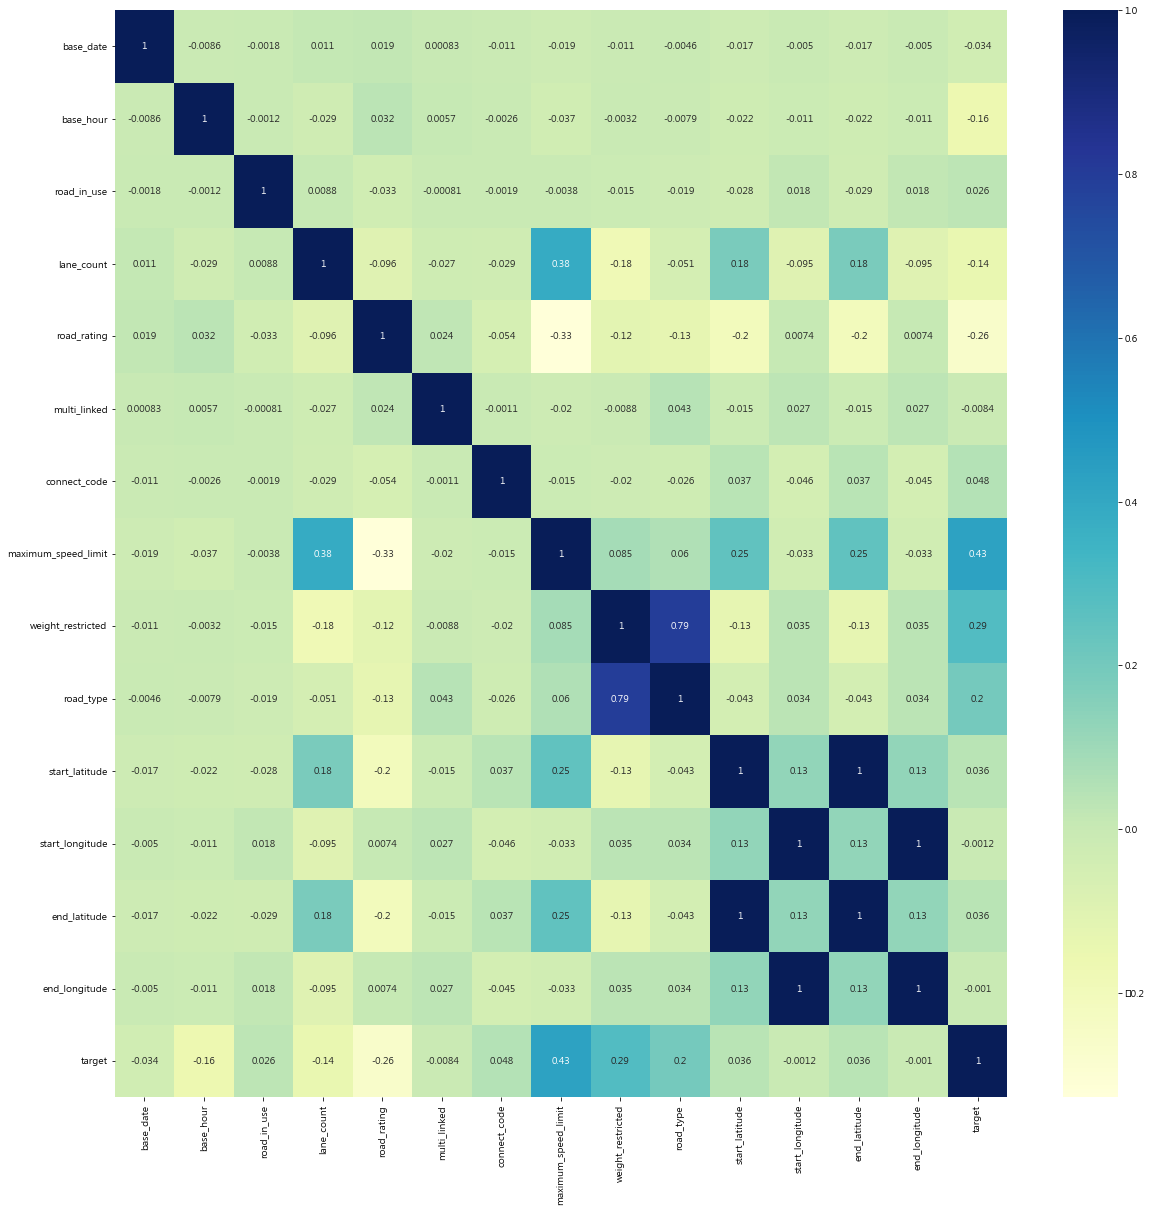

In [9]:
corr= train.corr()

plt.rcParams['figure.figsize'] = [20, 20]
sns.heatmap(corr, annot= True, cmap = 'YlGnBu' )

#### 2. 데이터 전처리 및 파생 변수 추가

In [10]:
# ['base_date'] -> # 월, 일 파생 변수 추가


train['base_date'].head()
'''
0    20211231
1    20220308
2    20220119
3    20220711
4    20211202   # 월, 일로 split
'''

# train
train['month'] = train['base_date'].astype('str').str[4:6].astype('int')
train['day'] = train['base_date'].astype('str').str[6:].astype('int')

# test
test['month'] = test['base_date'].astype('str').str[4:6].astype('int')
test['day'] = test['base_date'].astype('str').str[6:].astype('int')

Text(0, 0.5, '평균 속도 (km/h)')

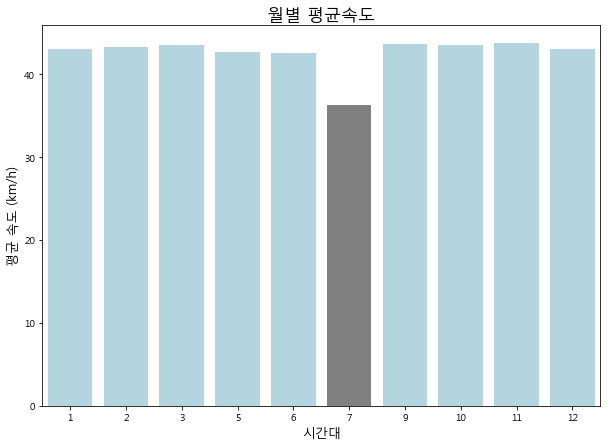

In [11]:
import seaborn as sns
plt.figure(figsize=(10,7))
values  = train.groupby('month').mean()['target']
idx = values.index
palette =['grey' if x == min(values.values) else 'lightblue' for x in values]
sns.barplot(idx, values.values, palette=palette )
plt.title("월별 평균속도", fontsize=17)
plt.xlabel('시간대', fontsize=13)
plt.ylabel('평균 속도 (km/h)', fontsize=13)

- 7월 평균 속도 : 30km/h대 중반
- 7월 제외 평균 속도 : 40km/h대 초중반 


-> 월별 평균 속도는, 7월달만 30km/h 중반으로 낮게 나타남 

In [12]:
# 계절 파생변수 추가

#봄   3,4,5월    -> 1 
#여름  6,7,8월    -> 2
#가을  9,10,11월  -> 3
#겨울  12,1,2월   -> 4

train.loc[(train['month'] == 3) | (train['month'] == 4) | (train['month'] == 5), 'season'] = 1     
train.loc[(train['month'] == 6) | (train['month'] == 7) | (train['month'] == 8), 'season'] = 2     
train.loc[(train['month'] == 9) | (train['month'] == 10) | (train['month'] == 11), 'season'] = 3  
train.loc[(train['month'] == 12) | (train['month'] == 1) | (train['month'] == 2), 'season'] = 4    


test.loc[(test['month'] == 3) | (test['month'] == 4) | (test['month'] == 5), 'season'] = 1   
test.loc[(test['month'] == 6) | (test['month'] == 7) | (test['month'] == 8), 'season'] = 2  
test.loc[(test['month'] == 9) | (test['month'] == 10) | (test['month'] == 11), 'season'] = 3   
test.loc[(test['month'] == 12) | (test['month'] == 1) | (test['month'] == 2), 'season'] = 4  

In [13]:
# 방학시즌 파생변수 추가

# 1,2,7,8 -> 1 
# 나머지 달 -> 0

train.loc[(train['month'] == 7) | (train['month'] == 8) | (train['month'] == 1) | (train['month'] == 2), 'vacation'] = 1  
train['vacation'] = train['vacation'].fillna(0)
    
test.loc[(test['month'] == 7) | (test['month'] == 8) | (test['month'] == 1) | (test['month'] == 2), 'vacation'] = 1  
test['vacation'] = test['vacation'].fillna(0)


In [14]:
df = pd.pivot_table(train, index='month', columns='base_hour', values = 'target', aggfunc='mean')
df2 = df.reset_index().melt(value_name='target', id_vars='month')

Text(0, 0.5, '평균 속도 (km/h)')

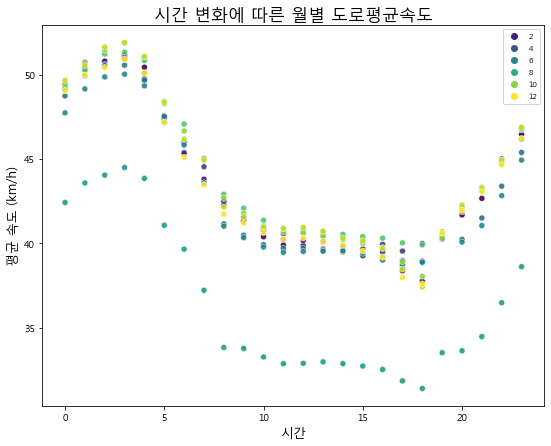

In [15]:
# 월별 시간대별 평균속도 ㅣ  # x축은 시간(0~24), y축은 평균 속도, color는 월 

plt.figure(figsize=(9,7))
ax = sns.scatterplot(data=df2, x='base_hour', y='target', hue='month', palette='viridis', alpha=0.9),              
plt.title("시간 변화에 따른 월별 도로평균속도", fontsize=17)
plt.legend(fontsize=8)
plt.xlabel('시간', fontsize=13)
plt.ylabel('평균 속도 (km/h)', fontsize=13)

#### - 시간대에 따라 평균 속도가 달라지는 것을 확인. 

#### - 7월이 전시간대에 걸쳐 다른 달에 비해 평균속도가 약 7~9km/h 정도 낮게 나타나고 있음    
    (휴가철로 인해 많은 관광객들의 방문으로 인한 것으로 유추)


#### - 시간대별 속도 변화 패턴은 시기와 관계없이 비슷함. 

- 오후 6시 -> 익일 새벽 3시 : 교통량 감소   
- 새벽 3시 -> 저녁 6시 : 교통량 증가   
- (새벽 4시~ 아침 8시 : 교통량이 빠르게 증가하는 구간)   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


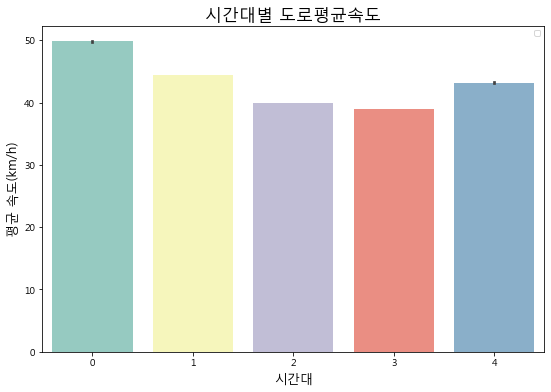

In [16]:
# [base_hour]

# 위의 시각화 정보를 통해, 시간을 아래와 같이 구간화하여 라벨 인코딩 

# 00~04 : 0 
# 05~08 : 1
# 09~15 : 2
# 16~19 : 3
# 20~23 : 4


# train
li = []
for i in train['base_hour'] : 
    if (i <=4) :
        li.append(0)
    elif (i <= 8) :
        li.append(1)
    elif (i <= 15) :
        li.append(2)
    elif (i <= 19) :
        li.append(3)
    else :
        li.append(4)
        
train['base_hour_le'] = li
   

#test
li = []
for i in test['base_hour'] : 
    if (i <=4) :
        li.append(0)
    elif (i <= 8) :
        li.append(1)
    elif (i <= 15) :
        li.append(2)
    elif (i <= 19) :
        li.append(3)
    else :
        li.append(4)
        
test['base_hour_le'] = li

fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=train, x='base_hour_le', y='target', palette='Set3') 
plt.xlabel('시간대', fontsize=13)
plt.ylabel('평균 속도(km/h)', fontsize=13)
plt.title("시간대별 도로평균속도", fontsize=17)
plt.legend(fontsize=8)

# 00~04 : 0  가장 속도가 높음
# 05~08 : 1
# 09~15 : 2
# 16~19 : 3  가장 속도가 낮음
# 20~23 : 4

0 (00-04시) : 평균 속도가 가장 높은 시간대 (교통량 적음)   
1 (05-08시)     
2 (09-15시)  
3 (16-19시) :  평균 속도가 가장 낮은 시간대 (교통량 많음)  
4 (20-23시)   

Text(0.5, 1.0, '요일별 도로 평균속도')

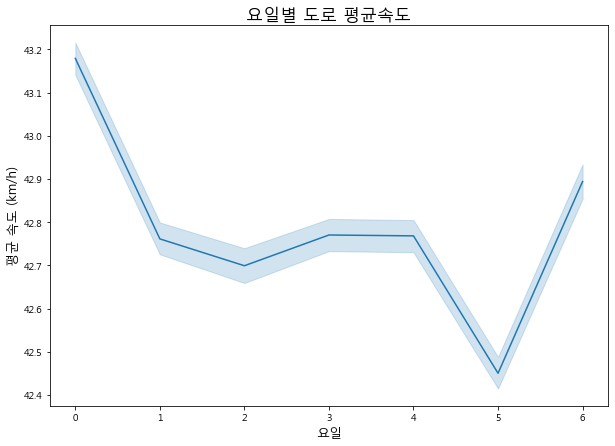

In [17]:
# [day_of_week] 

# 요일 : 요일순으로 라벨 인코딩

# '일':0, '월':1, '화':2, '수':3, '목':4, '금':5, '토':6

요일 = {'일':0, '월':1, '화':2, '수':3, '목':4, '금':5, '토':6}

# train 
train['day_of_week_2'] = train['day_of_week'].replace(요일)

# test
test['day_of_week_2'] = test['day_of_week'].replace(요일)


# 요일별 평균속도 ㅣ  # x축은 시간(0~24), y축은 평균 속도

fig, ax = plt.subplots(figsize=(10,7))
plt.xlabel('요일', fontsize=13)
plt.ylabel('평균 속도 (km/h)', fontsize=13)
sns.lineplot(data = train, x='day_of_week_2', y= 'target')
plt.title("요일별 도로 평균속도", fontsize=17)

금요일 평균속도가 가장 낮고, 일요일 평균속도가 가장 높음     

( 요일별 평균 속도: 일 > 토 > 월~목 > 금 )

In [18]:
# 요일 라벨인코딩 두 번째 

# 위의 시각화 결과를 참고하여, 월~몯/금요일/토요일/일요일 따로 구분하여 인코딩

# 금 : 0
# 월~목 : 1
# 토 : 2
# 일 : 3

요일 = {'일':3, '월':1, '화':1, '수':1, '목':1, '금':0, '토':2}

# train 
train['day_of_week_3'] = train['day_of_week'].replace(요일)

# test
test['day_of_week_3'] = test['day_of_week'].replace(요일)

In [19]:
# [base_date] 

# 날짜 관련 파생변수 추가 -> 평일 / 주말휴일 

# 평일 : 0 
# 주말or휴일 : 1 
 
    
공휴일 =   [ 20210920,20210921,20210922,20211003,
           20211004,20211009,20211011,20211225,
           20220101,20220131,20220201,20220202,
           20220301,20220309,20220505,20220508,
           20220601,20220606,20220815]



train.loc[train['day_of_week_2'].isin(range(1,6)) == True,'평일/공휴일'] = 0  # 평일 : 0
train.loc[train['day_of_week_2'].isin([0,6]) == True,'평일/공휴일'] = 1       # 주말 : 1
train.loc[train['base_date'].isin(공휴일),'평일/공휴일'] = 1   # 법정/대체공휴일 : 1



test.loc[test['day_of_week_2'].isin(range(1,6)) == True,'평일/공휴일'] = 0  # 평일 : 0
test.loc[test['day_of_week_2'].isin([0,6]) == True,'평일/공휴일'] = 1       # 주말 : 1
test.loc[test['base_date'].isin(공휴일),'평일/공휴일'] = 1   # 법정/대체공휴일 : 1

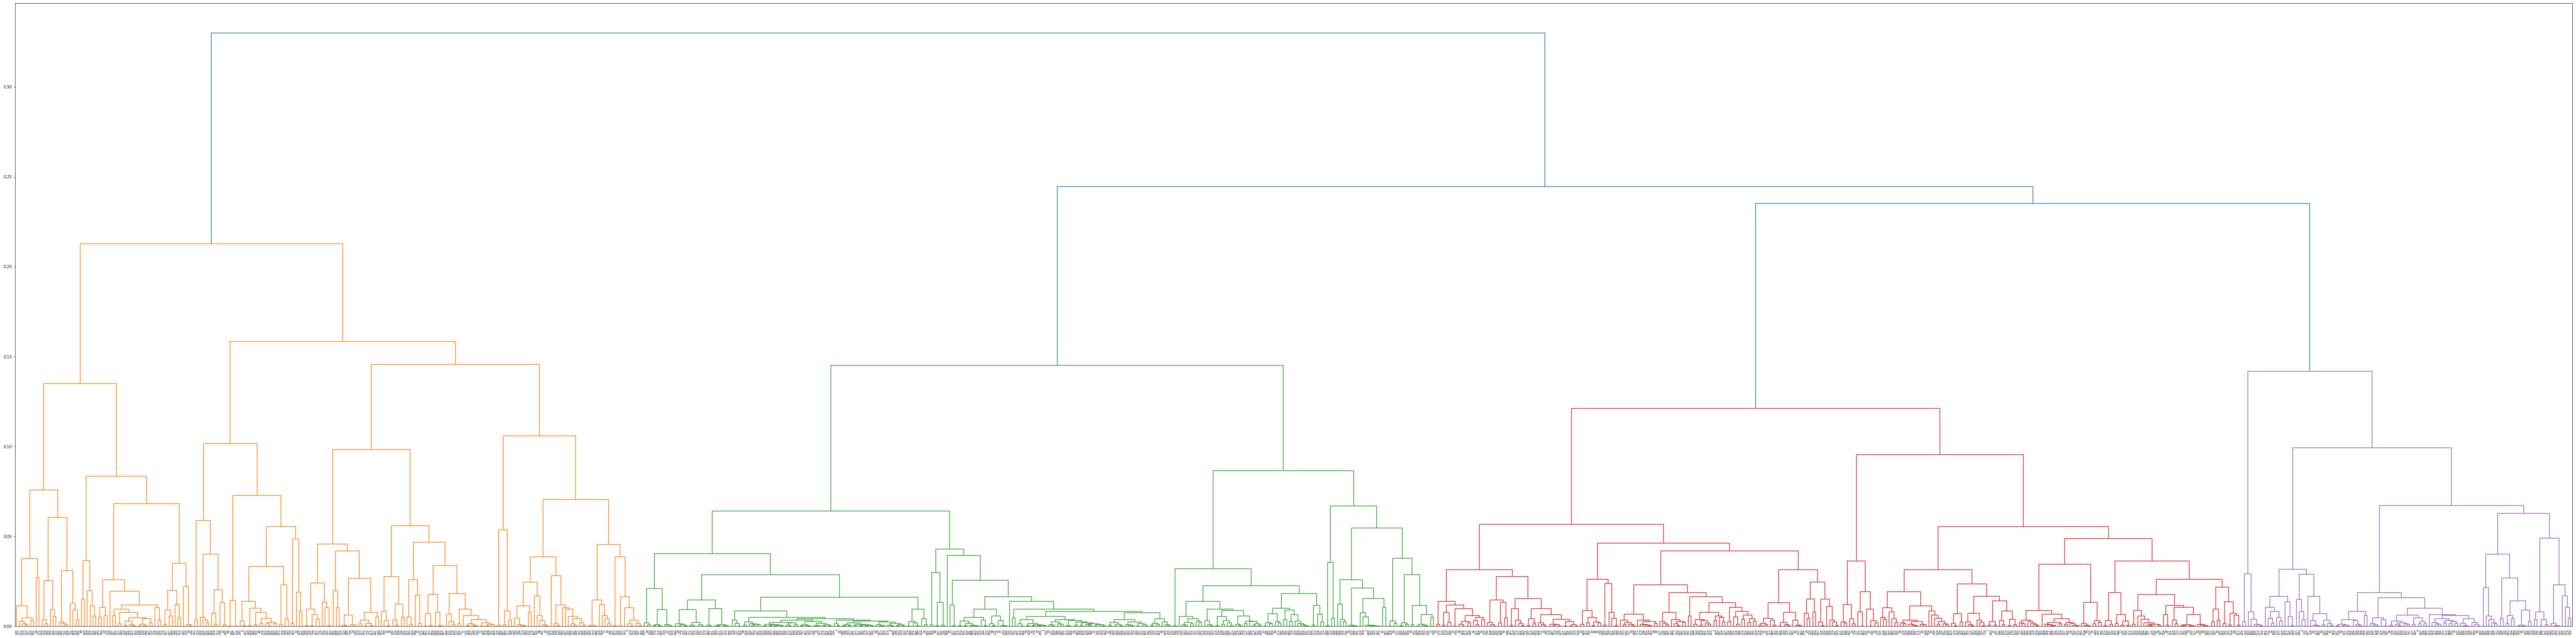

In [20]:
# 도로 중간 지점 게층적 군집화 및 라벨 부여 -> 파생변수 생성 

# ['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']  -> ['mid_latitude', mid_longitude]


위경도 = train[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']] .drop_duplicates().reset_index(drop=True)  # 중복값 제거 

중간지점 = pd.DataFrame()
위경도['mid_latitude'] = (위경도['start_latitude']+위경도['end_latitude'])/2
위경도['mid_longitude'] = (위경도['end_longitude']+위경도['end_longitude'])/2
중간지점 = 위경도[['mid_latitude','mid_longitude']]


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

중간지점_clusters = linkage(pdist(중간지점), metric = 'euclidean', method='average')

plt.rcParams['figure.figsize'] = [100,25]

중간지점leaves = dendrogram(중간지점_clusters, leaf_font_size=7)['leaves']

In [21]:
# 군집을 4개로 만들어 레이블링

from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=4, affinity ='euclidean', linkage='ward')
labels_4 = ac.fit_predict(중간지점)
print('클러스터 레이블 : %s' %labels_4)

클러스터 레이블 : [2 1 0 3 0 3 0 1 3 2 1 3 2 3 3 1 1 1 1 2 1 3 1 3 3 3 3 1 0 1 1 3 0 1 3 3 0
 1 1 1 0 0 3 1 0 1 3 0 1 2 1 1 1 1 0 3 2 3 1 1 1 1 3 3 1 3 3 3 2 1 1 0 3 2
 0 1 3 3 2 1 2 1 0 1 0 0 2 0 1 3 3 1 3 2 0 1 0 1 3 3 1 0 1 1 3 1 2 3 1 2 1
 1 2 1 0 3 2 3 0 2 3 3 2 1 3 1 2 0 0 1 0 1 2 3 1 1 1 3 3 3 0 0 3 3 3 0 2 2
 1 1 2 1 1 1 3 2 3 1 1 1 1 0 0 0 3 1 1 0 1 0 1 1 1 0 1 3 2 2 2 3 0 0 3 3 1
 0 0 1 2 0 1 3 3 2 0 2 1 0 0 2 0 0 3 3 1 3 3 1 1 3 1 0 2 3 0 0 1 3 1 1 1 1
 3 3 0 3 0 1 3 1 0 0 0 0 1 1 2 0 1 1 3 3 0 2 3 2 1 1 0 1 1 3 0 3 3 3 1 3 3
 1 0 1 1 3 2 2 0 1 3 2 3 3 3 1 1 2 1 0 2 0 0 3 1 1 3 0 2 3 2 2 1 3 3 1 2 1
 3 1 3 1 3 1 1 1 0 0 2 1 1 3 3 1 1 0 1 0 1 2 3 1 0 2 3 1 2 0 3 0 1 0 1 0 3
 1 0 0 1 1 0 2 2 3 1 2 3 1 3 0 0 3 1 3 1 3 1 1 1 2 0 1 1 3 1 2 0 2 1 3 3 1
 2 1 1 3 2 1 3 3 2 1 3 2 3 3 0 0 3 3 3 2 2 3 3 1 1 2 3 1 3 0 0 2 1 1 1 3 2
 3 0 2 1 1 0 3 3 1 2 1 0 1 3 3 3 3 3 1 0 2 1 3 3 1 1 0 1 0 1 3 2 3 1 3 1 3
 0 2 1 1 1 1 3 1 0 2 0 1 3 2 1 2 2 3 3 3 0 1 0 2 3 3 3 1 2 0 3 1 0 1 2 0 2
 0 0 1 1 0 0 0

<AxesSubplot:xlabel='mid_longitude', ylabel='mid_latitude'>

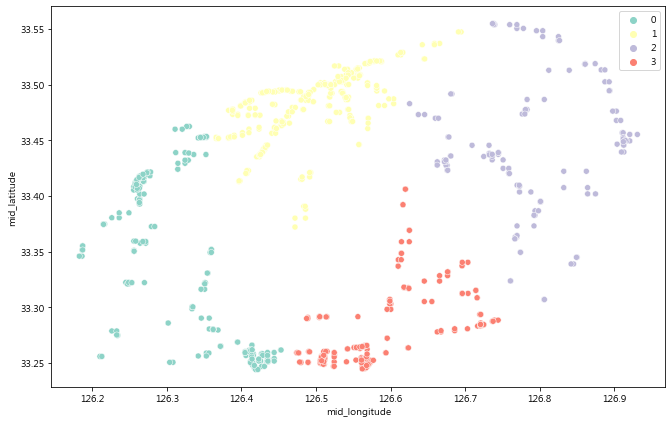

In [22]:
# 군집 시각화 
plt.figure(figsize= (11,7))
sns.scatterplot(data=위경도, y='mid_latitude', x='mid_longitude', hue = labels_4, palette='Set3')

In [23]:
# 군집을 13개로 만들어 레이블링

from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=13, affinity ='euclidean', linkage='ward')
labels_13 = ac.fit_predict(중간지점)
print('클러스터 레이블 : %s' %labels_13)

클러스터 레이블 : [ 6  5  1 11  3  9  3  2  9  8  2 11  6 11  0  5  5  2  2  7  5  0 12  9
  9 11  9  2  1 12  2  0  3  5  0 11  3  5  5  5  3  3 11  2  3 12  0  1
  2  8  2 12  5  5  1  9  8  9  2  5  5  2  9 11  5  9  9 11  6  2  2  1
  0  8  3  5 11  0  6  2  6  2  3  2  1  4 10  1  2 11 11  2 11  7  3  5
  1  2 11  9  2  1  2  5 11  5  6  0  5  8  5  2  8  2  4 11 10  9  1  6
  9 11  7  5  0  2  8  3  3  2  3 12  6 11  2  2  5  0  0 11  3  4 11 11
  9  1  7  6 12  5 10  2  2  2  9  8 11  5  5  2  5  3  1  1  9  2  5  3
 12  3  2  5  2  1  2  9  8 10  6  9  4  1 11 11  5  1  3  2  6  4  2 11
  0  7  4  6  2  1  1  6  3  4  9  9  2  0  9  5  5 11  2  3 10 11  1  1
  5  0  2  5  2  2 11  9  1 11  1  5 11  5  1  3  3  3  2 12  6  3  5  2
 11 11  1  8 11  6  2  2  4  2  5  0  3 11 11  0  2  0  9 12  4  5  2  0
  7  6  3  2  0  8 11  0 11  5  5 10 12  4  7  1  1  0  2  2  0  1 10  9
  6  7  2  9  0  5  6  2  9  2 11 12  9  2  2  2  1  3  8  2  2 11  0  2
  5  4  5  3 12  7  9  5  1  8 11  2  7 

In [24]:
위경도['labels_4'] = labels_4
위경도_2 = 위경도.loc[중간지점leaves]
위경도_2['index']=range(0,904)
위경도_2 = 위경도_2.sort_index()
위경도['index']=위경도_2['index']

In [25]:
위경도

,start_latitude,start_longitude,end_latitude,end_longitude,mid_latitude,mid_longitude,labels_4,index
0,33.427747,126.662612,33.427749,126.662335,33.427748,126.662335,2,80
1,33.500730,126.529107,33.504811,126.526240,33.502771,126.526240,1,600
2,33.279145,126.368598,33.280072,126.362147,33.279609,126.362147,0,477
3,33.246081,126.567204,33.245565,126.566228,33.245823,126.566228,3,363
4,33.462214,126.326551,33.462677,126.330152,33.462446,126.330152,0,808
...,...,...,...,...,...,...,...,...
899,33.275044,126.233440,33.275374,126.232714,33.275209,126.232714,0,791
900,33.299096,126.333777,33.301777,126.334881,33.300436,126.334881,0,492
901,33.288368,126.655400,33.322018,126.645196,33.305193,126.645196,3,114
902,33.246912,126.568186,33.248633,126.567766,33.247773,126.567766,3,385


In [26]:
위경도['labels_13']=labels_13

<AxesSubplot:xlabel='mid_longitude', ylabel='mid_latitude'>

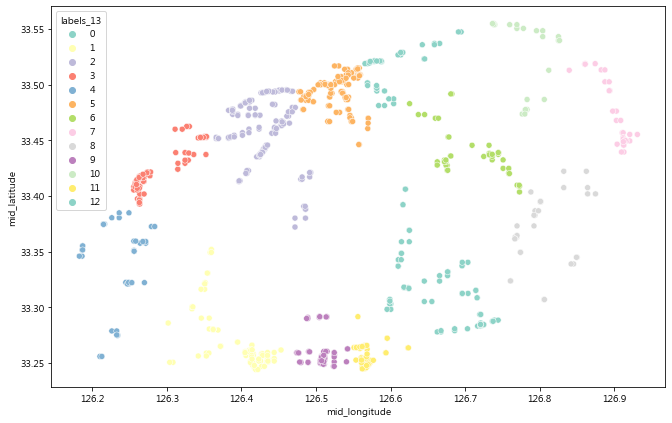

In [27]:
# 군집 시각화 
plt.figure(figsize= (11,7))
sns.scatterplot(data=위경도, y='mid_latitude', x='mid_longitude', hue = 'labels_13', palette='Set3')

In [28]:
위경도

,start_latitude,start_longitude,end_latitude,end_longitude,mid_latitude,mid_longitude,labels_4,index,labels_13
0,33.427747,126.662612,33.427749,126.662335,33.427748,126.662335,2,80,6
1,33.500730,126.529107,33.504811,126.526240,33.502771,126.526240,1,600,5
2,33.279145,126.368598,33.280072,126.362147,33.279609,126.362147,0,477,1
3,33.246081,126.567204,33.245565,126.566228,33.245823,126.566228,3,363,11
4,33.462214,126.326551,33.462677,126.330152,33.462446,126.330152,0,808,3
...,...,...,...,...,...,...,...,...,...
899,33.275044,126.233440,33.275374,126.232714,33.275209,126.232714,0,791,4
900,33.299096,126.333777,33.301777,126.334881,33.300436,126.334881,0,492,1
901,33.288368,126.655400,33.322018,126.645196,33.305193,126.645196,3,114,0
902,33.246912,126.568186,33.248633,126.567766,33.247773,126.567766,3,385,11


In [29]:
# 도로의 중간지점을 구하고, KMeans 군집분석을 통해 13개의 군집으로 나누었다.  

from sklearn.cluster import KMeans

KM = KMeans(n_clusters=13, n_init=50, max_iter=2000, algorithm = 'auto', random_state = 1234)  # 군집 30개로 나눔 
위경도['KMeans군집'] = KM.fit_predict(중간지점)
위경도['KMeans군집'].value_counts()
#train = pd.merge(train, df, on=['mid_latitude','mid_longitude'])

6     129
4     111
2     101
11     94
3      85
0      72
5      60
7      58
1      53
10     44
9      36
12     34
8      27
Name: KMeans군집, dtype: int64

<AxesSubplot:xlabel='mid_longitude', ylabel='mid_latitude'>

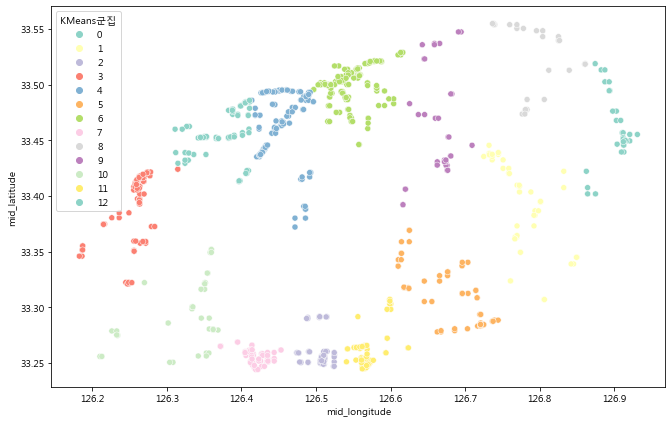

In [30]:
# KMeans군집 시각화 
plt.figure(figsize= (11,7))
sns.scatterplot(data=위경도, y='mid_latitude', x='mid_longitude', hue = 'KMeans군집', palette='Set3')

In [31]:
# 도로 길이 파생변수 추가 
# -> 도로 시작/도착 지점 위경도 값을 활용하여 도로 거리 도출

#!pip install haversine
from haversine import haversine


start_lat = pd.Series(위경도['start_latitude'])
start_lon = pd.Series(위경도['start_longitude'])
start_point = pd.Series(zip(start_lat,start_lon))
end_lat = pd.Series(위경도['end_latitude'])
end_lon = pd.Series(위경도['end_longitude'])
end_point = pd.Series(zip(end_lat,end_lon))

li =[]
for i in range(len(위경도)) : 
    a = haversine(start_point[i], end_point[i])
    li.append(round(a,3))
위경도['도로길이'] = li

In [32]:
위경도

,start_latitude,start_longitude,end_latitude,end_longitude,mid_latitude,mid_longitude,labels_4,index,labels_13,KMeans군집,도로길이
0,33.427747,126.662612,33.427749,126.662335,33.427748,126.662335,2,80,6,9,0.026
1,33.500730,126.529107,33.504811,126.526240,33.502771,126.526240,1,600,5,6,0.526
2,33.279145,126.368598,33.280072,126.362147,33.279609,126.362147,0,477,1,10,0.608
3,33.246081,126.567204,33.245565,126.566228,33.245823,126.566228,3,363,11,11,0.107
4,33.462214,126.326551,33.462677,126.330152,33.462446,126.330152,0,808,3,0,0.338
...,...,...,...,...,...,...,...,...,...,...,...
899,33.275044,126.233440,33.275374,126.232714,33.275209,126.232714,0,791,4,10,0.077
900,33.299096,126.333777,33.301777,126.334881,33.300436,126.334881,0,492,1,10,0.315
901,33.288368,126.655400,33.322018,126.645196,33.305193,126.645196,3,114,0,5,3.860
902,33.246912,126.568186,33.248633,126.567766,33.247773,126.567766,3,385,11,11,0.195


In [33]:
train = pd.merge(위경도, train, on= ['start_latitude','start_longitude','end_latitude', 'end_longitude'])
test = pd.merge(위경도, test, on= ['start_latitude','start_longitude','end_latitude', 'end_longitude'])

In [34]:
train['labeling1'] = train['labels_4']*1000 + train['index']
train['labeling2'] = train['labels_13']*1000 + train['index']
test['labeling1'] = test['labels_4']*1000 + test['index']
test['labeling2'] = test['labels_13']*1000 + test['index']

In [35]:
train.columns

Index(['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       'mid_latitude', 'mid_longitude', 'labels_4', 'index', 'labels_13',
       'KMeans군집', '도로길이', 'id', 'base_date', 'day_of_week', 'base_hour',
       'road_in_use', 'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_node_name', 'start_turn_restricted', 'end_node_name',
       'end_turn_restricted', 'target', 'month', 'day', 'season', 'vacation',
       'base_hour_le', 'day_of_week_2', 'day_of_week_3', '평일/공휴일', 'labeling1',
       'labeling2'],
      dtype='object')

Text(0.5, 1.0, '진입 제한 무게에 따른 도로 평균 속도')

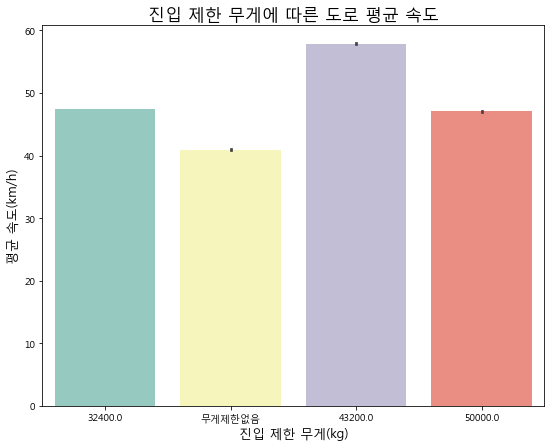

In [36]:
# [weight restricted] 
# 무게 제한 -> 라벨 인코딩 진행

train['weight_restricted'].unique()  
# array([32400.,     0., 43200., 50000.])

li = {0 : 0, 32400: 1, 43200 : 2, 50000:3}


# train
train['weight_restricted_2'] = train['weight_restricted'].replace(li)

# test
test['weight_restricted_2'] = test['weight_restricted'].replace(li)

plt.figure(figsize= (9,7))
제한무게 = train['weight_restricted'].replace({0:'무게제한없음'})
sns.barplot(제한무게, train['target'], palette='Set3')
plt.xlabel('진입 제한 무게(kg)',fontsize=13)
plt.ylabel('평균 속도(km/h)',fontsize=13)
plt.title("진입 제한 무게에 따른 도로 평균 속도", fontsize=17)

# 구분에 따라 평균 속도에 차이가 나타나기 때문에, 변수로 채택하도록 한다; 


Text(0.5, 1.0, '회전 제한 수에 따른 도로 평균 속도')

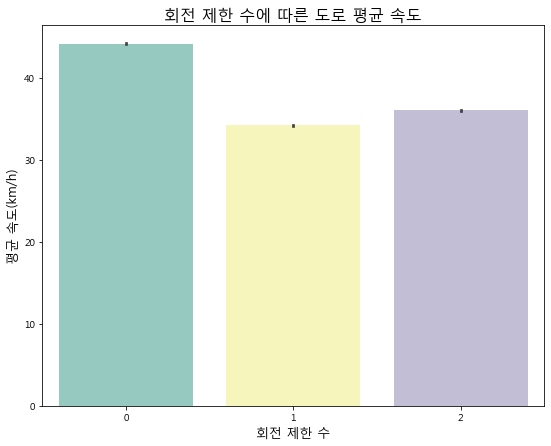

In [37]:
# [start_turn_restricted[, [end_turn_restricted]
# 도로 시작지점 회전제한여부  +  도로 끝지점 회전제한여부 -> 하나로 합쳐서 '회전 제한 수' 파생변수 생성

# 회전 제한 없음 :  0 
# 시작/도착 지점에 하나라도 존재 : 1
# 시작/도착 지점 둘 다 존재 :  2
    
    
    
dic = {'없음' : 0, '있음' : 1}
train['start_turn_restricted_2'] = train['start_turn_restricted'].replace(dic)
train['end_turn_restricted_2'] = train['end_turn_restricted'].replace(dic)
test['start_turn_restricted_2'] = test['start_turn_restricted'].replace(dic)
test['end_turn_restricted_2'] = test['end_turn_restricted'].replace(dic)
train['회전제한수'] = train['start_turn_restricted_2'] + train['end_turn_restricted_2']
test['회전제한수'] = test['start_turn_restricted_2'] + test['end_turn_restricted_2']

plt.figure(figsize= (9,7))
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

sns.barplot(train['회전제한수'], train['target'], palette='Set3')
plt.xlabel('회전 제한 수',fontsize=13)
plt.ylabel('평균 속도(km/h)',fontsize=13)
plt.title("회전 제한 수에 따른 도로 평균 속도", fontsize=16)


Text(0.5, 1.0, '제한속도에 따른 도로 평균 속도')

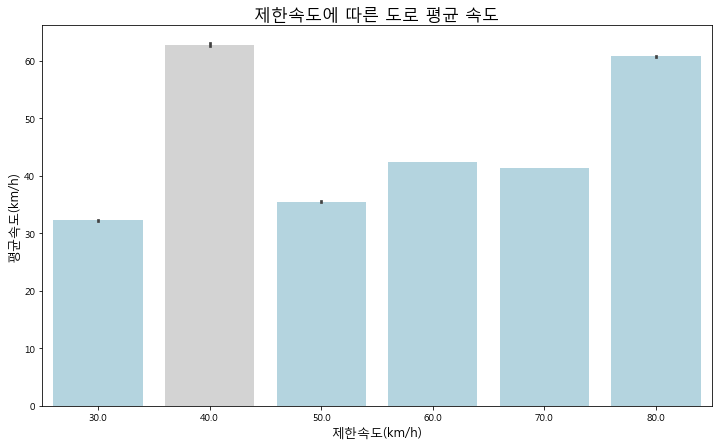

In [38]:
# ['maximum_speed_limit'] 제한 속도 
train['maximum_speed_limit'].unique() 
# array([30., 40., 50., 60., 70., 80.])

plt.figure(figsize=(12,7))
palette = ['lightblue','lightgrey','lightblue','lightblue','lightblue','lightblue']
sns.barplot(train['maximum_speed_limit'], train['target'], palette=palette)
plt.xlabel('제한속도(km/h)',fontsize=13)
plt.ylabel('평균속도(km/h)',fontsize=13)
plt.title("제한속도에 따른 도로 평균 속도", fontsize=17)

# 제한속도에 따라 평균 속도의 차이가 존재하기 때문에 변수로 채택 

제한 속도가 40km/h인 도로를 제외하면, 제한속도가 높아질 수록 평균속도도 증가하는 경향을 보임

(제한 속도가 40km/h인 도로의 평균 속도가 60km/h 초반으로 나타남)    


Text(0.5, 1.0, '도로 등급에 따른 평균 속도 차이')

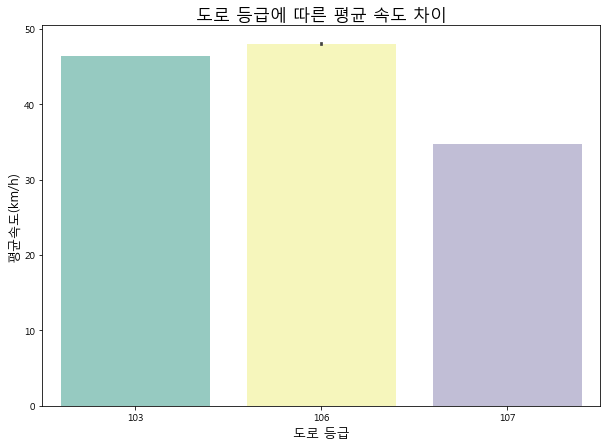

In [39]:
# [road_rating] 도로 등급 -> 라벨인코딩

train['road_rating'].unique()   # array([107, 103, 106])
test['road_rating'].unique()    # array([107, 103, 106])

# 103 : 0 
# 106 : 1
# 107 : 2

li = {103 : 0, 106 : 1, 107 : 2}

# train
train['road_rating_2'] = train['road_rating'].replace(li)

# test
test['road_rating_2'] = test['road_rating'].replace(li)


plt.figure(figsize=(10,7))
sns.barplot(train['road_rating'], train['target'], palette='Set3')    # 구분에 따라 평균 속도에 차이가 나타나기 때문에, 변수로 채택하도록 한다; 
plt.xlabel('도로 등급',fontsize=13)
plt.ylabel('평균속도(km/h)',fontsize=13)
plt.title("도로 등급에 따른 평균 속도 차이", fontsize=17)

In [40]:
# [start_node_name], [end_node_name]
# 시작지점 이름과 끝지점 이름을 합쳐서 라벨 인코딩

train['start_end_node_name']=(train['start_node_name'] +'_'+ train['end_node_name'] )
test['start_end_node_name']=(test['start_node_name'] +'_'+ test['end_node_name'] )

model = LabelEncoder() 
train['start_end_node_name_le'] = model.fit_transform(train['start_end_node_name'])
test['start_end_node_name_le'] = model.transform(test['start_end_node_name'])


In [41]:
train['start_node_name'].unique()

array(['제3교래교', '광양사거리', '창고천교', '남양리조트', '애월샷시', '시청입구2', '가동', '외도천교',
       '신성교회', '양수장', '노루생이', '선경오피스텔', '명도암교차로', '서홍교', '송목교', '아라초등학교앞',
       '그랜드호텔사거', '중산간서로6091', '광령3교차로', '오조한도교입구', '종합운동장입구사거리',
       '동부장의운수사', '양천동', '한솔고기국수', '제5산록교', '강정교', '어시천교', '광평교차로',
       '버으내교차로', '일호유리', '남수교', '남읍학교살리기다가구', '거로마을', '서현주택', '명월교',
       '연동사거리', '제주일보사거리', '인다마을', '창성세차장', '오당빌레길1', '수복당', '해안동804-4',
       '노을과포도향기', '다이소제주화북점', '수장교', '동광램프(서귀포)', '경마장교', '난산사거리', '미수2교',
       '동중입구', '창천교', '수모루교차로', '성읍교차로', '오봉교', '아라주공아파트', '고성교차로',
       '서호2차현대맨션203동', '김약국', '국립제주박물관', '서귀포경찰서', '동홍사거리', '제2성읍교',
       '하귀입구', '서원', '동광2교차로', '진은교', '성읍사거리', '수협중앙회', '부영아파트', '청상어식당',
       '농협하나로마트', '봉좌교', '제4교래교', '양계장', '쉬는팡교차로', '한라교', '중문한의원',
       '월림삼거리', '평대초교앞', '세훈빌리지', '제1해안교', '상효2교', '뉴본아파트', '어리목입구',
       'BYC', '연수동삼거리', '농협창고', '제2거로교', '제2봉성교', '광명제2교차로', '경동보일러',
       '구엄교', '색달동마을', '어승생삼거리', '난지농업연구소삼거리', '정방수퍼', '중앙여고사거리', '제2의귀교',
       '거

Text(0.5, 1.0, '도로 시작 지점 종류(교차로/다리/일반도로/그외)에 따른 평균속도')

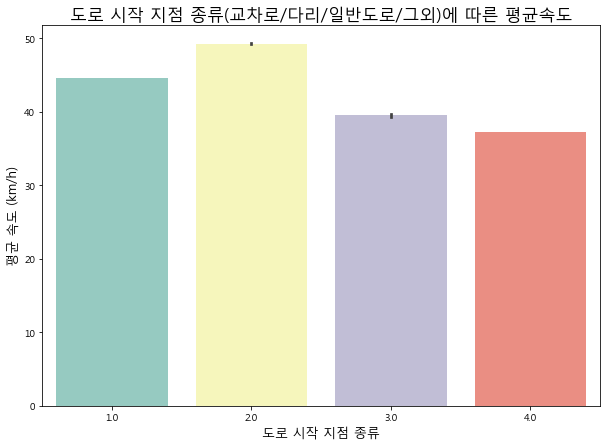

In [42]:
# ['start_node_name']를 아래와 같이 분류하고, 분류에 따라 평균속도의 차이가 있는지 확인 

#교차로, 삼거리, 사거리 : 1
#~교(다리) : 2 
#~로(일반도로) : 3 
#그 외 : 4 


# train data 

# 교차로, 삼거리, 사거리 
교차로 = train['start_node_name'].str.match(re.compile('.+[교][차].+'))
삼거리 = train['start_node_name'].str.match(re.compile('.+[삼][거][리]'))
사거리 = train['start_node_name'].str.match(re.compile('.+[사][거][리]'))
train.loc[교차로|삼거리|사거리, 'start_node_name_2']=1

# ~교(다리)
교 = train['start_node_name'].str.match(re.compile('.+[교]$'))
train.loc[교, 'start_node_name_2']=2

# ~로(일반도로) 
로 = train['start_node_name'].str.contains('.+[로]$', regex=True)
train.loc[~교차로&로, 'start_node_name_2']=3

# 그 외
train.loc[train['start_node_name_2'].isna(),'start_node_name_2']=4



# test data 

교차로 = test['start_node_name'].str.match(re.compile('.+[교][차].+'))
삼거리 = test['start_node_name'].str.match(re.compile('.+[삼][거][리]'))
사거리 = test['start_node_name'].str.match(re.compile('.+[사][거][리]'))
test.loc[교차로|삼거리|사거리, 'start_node_name_2']=1

# ~교(다리)
교 = test['start_node_name'].str.match(re.compile('.+[교]$'))
test.loc[교, 'start_node_name_2']=2

# ~로(일반도로)  
로 = test['start_node_name'].str.contains('.+[로]$', regex=True)
test.loc[~교차로&로, 'start_node_name_2']=3

# 그 외
test.loc[test['start_node_name_2'].isna(),'start_node_name_2']=4


plt.figure(figsize=(10,7))
sns.barplot(train['start_node_name_2'], train['target'], palette='Set3')
plt.xlabel('도로 시작 지점 종류', fontsize=13)
plt.ylabel('평균 속도 (km/h)', fontsize=13)
plt.title("도로 시작 지점 종류(교차로/다리/일반도로/그외)에 따른 평균속도", fontsize=17)


# 분류에 따라 평균 속도의 차이가 확인 되어, 변수로 채택함                                        


교차로, 삼거리, 사거리 : 1   
~교(다리) : 2    
~로(일반도로) : 3    
그 외 : 4    

시작 지점이 교량일 때 도로의 평균 속도가 가장 높게 나타나는 것을 알 수 있다. (49km/h)      
차선이 모이는 교차로에서의 평균 속도가 가장 낮을 것으로 예상했으나, 교량에 이어 두 번째로 높은 평균속도를 보였다.(44km/h)

In [43]:
train['end_node_name'].unique()

array(['제3교래교', 'KAL사거리', '상창육교', '서현주택', '애월입구', '서호2차현대맨션203동', '나동',
       '외도천교', '제2가시교', '노루생이삼거리', '정방수퍼', '버으내교차로', '서흥동사무소', '송목교',
       '제2아라교', '흘천5교', '장전1교차로', '고성교차로', '송내교차로', '동산교', '농업용관정',
       '뱅듸왓교차로', '삼주연립101동', '제4산록교', '서홍교', '도순교', '어시천교', '금악',
       '명도암교차로', '상귀교차로', '남수교', '고산전화국', '별도교', '팔도철물건재', '명월교',
       '신제주초교입구오거리', '삼무공원사거리', '아라주공아파트', '농협주유소', '고하상로교차로', '부부식당',
       '해안육교', '오당빌레길1', '삼양교(서측)', '수장교', '상창교차로', '경마장교', '난산입구',
       '미수2교', '다이소제주화북점', '염광아파트', '남녕고앞사거리', '창천교', '수모루', '성읍삼거리',
       '제5산록교', '오장교', '인다마을', '제3고성교', '시청입구2', 'BYC', '거로사거리', '용당교차로',
       '의료보험조합', '대흥개발(주)', '성읍2리', '일호유리', '유수암교차로', '전표1교', '진은교',
       '한림어촌계', '제주일고', '수복당', '천주교회', '제2성읍교', '봉좌교', '제주삼다수', '구엄교',
       '더럭초교차로', '한라교', '신양약방', '월림', '비자림입구', '중문입구', '해안마을', '상효2교',
       '선경오피스텔', '어리목입구', '김약국', '세화입구', '원일공사', '봉성교차로', '광령2교차로',
       '서흥사거리', '월드컵경기장', '오돌또기', '색달교', '어승생삼거리', '한북교', '우성사료', '연북5교',
       '제4교래교', '제2의귀교

Text(0.5, 1.0, '도로 도착 지점 종류(교차로/다리/일반도로/그외)에 따른 평균속도')

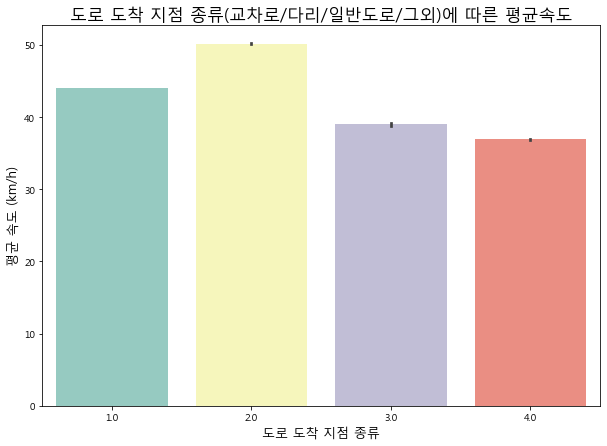

In [44]:
# end_node_name를 아래와 같이 분류하고, 분류에 따라 평균속도의 차이가 있는지 확인 

# 교차로, 삼거리, 사거리 : 1
# ~교(다리) : 2 
# ~로(일반도로) : 3 
# 그 외 : 4 


# train data 

# 교차로, 삼거리, 사거리 
교차로 = train['end_node_name'].str.match(re.compile('.+[교][차].+'))
삼거리 = train['end_node_name'].str.match(re.compile('.+[삼][거][리]'))
사거리 = train['end_node_name'].str.match(re.compile('.+[사][거][리]'))
train.loc[교차로|삼거리|사거리, 'end_node_name_2']=1

# ~교(다리)
교 = train['end_node_name'].str.match(re.compile('.+[교]$'))
train.loc[교, 'end_node_name_2']=2

# ~로(일반도로)
로 = train['end_node_name'].str.contains('.+[로]$', regex=True)
train.loc[~교차로&로, 'end_node_name_2']=3

# 그 외
train.loc[train['end_node_name_2'].isna(),'end_node_name_2']=4



# test data 

# 교차로, 삼거리, 사거리 
교차로 = test['end_node_name'].str.match(re.compile('.+[교][차].+'))
삼거리 = test['end_node_name'].str.match(re.compile('.+[삼][거][리]'))
사거리 = test['end_node_name'].str.match(re.compile('.+[사][거][리]'))
test.loc[교차로|삼거리|사거리, 'end_node_name_2']=1

# ~교(다리)
교 = test['end_node_name'].str.match(re.compile('.+[교]$'))
test.loc[교, 'end_node_name_2']=2

# ~로(일반도로)
로 = test['end_node_name'].str.contains('.+[로]$', regex=True)
test.loc[~교차로&로, 'end_node_name_2']=3

# 그 외
test.loc[test['end_node_name_2'].isna(),'end_node_name_2']=4

plt.figure(figsize=(10,7))
sns.barplot(train['end_node_name_2'], train['target'], palette='Set3')
plt.xlabel('도로 도착 지점 종류',fontsize=13)
plt.ylabel('평균 속도 (km/h)',fontsize=13)
plt.title("도로 도착 지점 종류(교차로/다리/일반도로/그외)에 따른 평균속도", fontsize=17)


# 분류에 따라 평균 속도의 차이가 확인 됨

교차로, 삼거리, 사거리 : 1   
~교(다리) : 2    
~로(일반도로) : 3    
그 외 : 4    

도로 도착 지점이 교량일 때 도로의 평균 속도가 가장 높게 나타나는 것을 알 수 있다. (49km/h)      
차선이 모이는 교차로에서의 평균 속도가 가장 낮을 것으로 예상했으나, 교량에 이어 두 번째로 높은 평균속도를 보였다.(44km/h)

Text(0.5, 1.0, '도로 종류에 따른 평균속도')

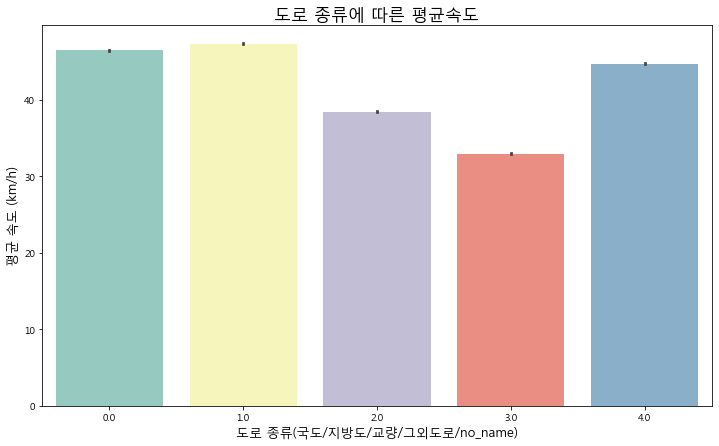

In [45]:
# train['road_name']를 국도/지방도/교량/그 외 도로/'-'로 범주화

# 국도 : 0, 지방도 : 1, 교량 : 2, 그 외 도로 : 3, '-' : 4

train['road_name'].unique()
'''
      (['-', '일반국도99호선', '태평로', '중앙로', '관광단지1로', '지방도1132호선', '중정로', '동홍로',
       '동문로', '새서귀로', '관광단지2로', '경찰로', '일반국도12호선', '관광단지로', '권학로', '중문로',
       '시민광장로', '시청로', '호서중앙로', '호근로', '일반국도16호선', '산서로', '지방도1136호선',
       '지방도1116호선', '지방도1118호선', '지방도1115호선', '일반국도11호선', '일반국도95호선',
       '남조로', '지방도1120호선', '지방도1119호선', '지방도97호선', '지방도1117호선',
       '지방도1112호선', '애원로', '중산간서로', '첨단로', '애조로', '번영로', '아봉로', '연북2교',
       '어시천교', '외도천교', '연동로', '연북로', '고평교', '신광로', '삼무로', '연삼로', '신대로',
       '서사로', '수영장길', '한천로', '신산로', '삼성로', '동부관광도로', '제2거로교', '관덕로',
       '임항로', '삼봉로', '일주동로'], dtype=object)
'''

# train
국도 = train['road_name'].str.contains(re.compile('.+[국][도].+'))
지방도 = train['road_name'].str.contains(re.compile('[지][방][도].+'))
교량 = train['road_name'].str.contains(re.compile('.+[교]$'))
그외도로 = train['road_name'].str.contains(re.compile('.+[로길]$'))
no_name = train['road_name'].str.contains(re.compile('-'))

train.loc[국도, 'road_name_2'] = 0
train.loc[지방도, 'road_name_2'] = 1
train.loc[교량, 'road_name_2'] = 2
train.loc[그외도로, 'road_name_2'] = 3
train.loc[no_name, 'road_name_2'] = 4


# test
국도 = test['road_name'].str.contains(re.compile('.+[국][도].+'))
지방도 = test['road_name'].str.contains(re.compile('[지][방][도].+'))
교량 = test['road_name'].str.contains(re.compile('.+[교]$'))
그외도로 = test['road_name'].str.contains(re.compile('.+[로길]$'))
no_name = test['road_name'].str.contains(re.compile('-'))


test.loc[국도, 'road_name_2'] = 0
test.loc[지방도, 'road_name_2'] = 1
test.loc[교량, 'road_name_2'] = 2
test.loc[그외도로, 'road_name_2'] = 3
test.loc[no_name, 'road_name_2'] = 4

plt.figure(figsize=(12,7))
sns.barplot(train['road_name_2'], train['target'], palette='Set3')  
plt.xlabel('도로 종류(국도/지방도/교량/그외도로/no_name)',fontsize=13)
plt.ylabel('평균 속도 (km/h)',fontsize=13)
plt.title("도로 종류에 따른 평균속도", fontsize=17)
# 도로 종류에 따라 평균 속도에 차이가 나타남

##### 3.  외부 데이터 추가 

#### 3-1. 외부 데이터 수집
#### 주변 관광지, 유흥 업소, 음식점 
: 유동인구와 관련된 데이터로, 도로 교통량이 달라질 것이라 예상하여 데이터를 수집
#### 도로의 cctv 
: cctv가 차량의 속도에 영향을 줄 것으로 판단하여 데이터를 수집
#### 주유소, 전기차 충전소 
: 차량이 많이 다니는 곳 근처에 주유소나 전기차 충전소가 있을 것으로 예상하여 데이터를 수집


In [46]:
# 관광지 데이터 예시

관광지 = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/관광지전체.csv', encoding='utf-8').drop('Unnamed: 0',1)
print(관광지.shape)
관광지.head(1)

(1136, 13)


,contents_id,contents_label,title,address,road_address,tag,introduction,latitude,longitude,post_code,phone_no,img_path,thumbnail_path
0,CNTS_000000000022691,관광지,오라동 청보리-메밀꽃밭,제주특별자치도 제주시 오라2동 산 76,제주특별자치도 제주시 오라2동 산 76,"경관/포토,친구,커플,맑음,봄,가을",한라산 아래 드넓은 청보리-메밀꽃의 향연,33.426865,126.505775,NaN,--,https://api.cdn.visitjeju.net/photomng/imgpath...,https://api.cdn.visitjeju.net/photomng/thumbna...


In [47]:
# 제주도 주유소 데이터 예시 
주유소 = pd.read_csv('/Users/EUNJI/Desktop/제주주유소.csv', encoding = 'cp949')
print(주유소.head())  # 위경도 데이터 없음 ->  주소를 위경도로 변환하기 


             상호                      주소           연락처     데이터기준일자
0    (주)무수천주유소      제주특별자치도 제주시 노형로 45   064-748-1515  2020-12-30
1  ㈜새신테크 이호주유소   제주특별자치도 제주시 일주서로 7629   064-747-0033  2020-12-30
2     (주)회천주유소     제주특별자치도 제주시 번영로 937   064-721-9222  2020-12-30
3       거북이주유소      제주특별자치도 제주시 서광로 58   064-743-4777  2020-12-30
4        고산주유소   제주특별자치도 제주시 한경면 고산로 5   064-772-2626  2020-12-30


In [48]:
# cctv 데이터 예시

cctv = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/cctv_원본.csv', encoding = 'cp949')
print(cctv.shape)
cctv.head(1)

(267, 21)


,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,...,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,관리기관명,관리기관전화번호,데이터기준일자
0,F6863,제주특별자치도,제주시,시도,NaN,서광로,2,제주특별자치도 제주시 한천로 4,제주특별자치도 제주시 오라삼동 2339-5,33.500441,...,오라로터리 (연동 → 광양),2,50,NaN,NaN,NaN,2013,제주특별자치도경찰청,064-798-3052,2022-06-16


In [49]:
# 전기차 충전소 데이터 예시
제주전기차충전소 = pd.read_csv('/Users/EUNJI/Desktop/제주전기차충전소.csv',  encoding = 'utf-8')
제주전기차충전소.head(1)

,Unnamed: 0,statNm,statId,chgerId,chgerType,addr,location,useTime,lat,lng,...,zcode,zscode,kind,kindDetail,parkingFree,note,limitYn,limitDetail,delYn,delDetail
0,0,제주종합경기장2,ME000466,1,6,제주특별자치도 제주시 서광로2길 24,NaN,24시간 이용가능,33.495507,126.516495,...,50,50110.0,A0,A004,N,NaN,N,NaN,N,NaN


In [50]:
# 위와 같이 위경도 데이터가 없는 경우엔, 주소를 좌표로 변환

# [Python] 카카오 API를 사용한 주소/위경도 추출 
import json
import requests
api_key = 'fa7a5167fc4f755d286530a0761869da'

def addr_to_lat_lon(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query={address}'.format(address=addr)
    headers = {"Authorization": "KakaoAK " + api_key}
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address']
    return float(match_first['y']), float(match_first['x'])

주유소좌표=[]
for i in 주유소['주소'] : 
    a = addr_to_lat_lon(i)
    주유소좌표.append(a)

주유소좌표

[(33.4634243137574, 126.451708979432),
 (33.4952778588982, 126.461778673461),
 (33.4758119847687, 126.636623779639),
 (33.4988463155675, 126.50270045834),
 (33.3014651927313, 126.179388240448),
 (33.5115364245863, 126.563216973289),
 (33.4933155561331, 126.483278530477),
 (33.4451175635388, 126.434137485625),
 (33.5056645200954, 126.953538281905),
 (33.5189802862537, 126.858715440628),
 (33.5188320112275, 126.86423200109),
 (33.4933158885673, 126.506948643564),
 (33.4797338191817, 126.399619208865),
 (33.5004951973269, 126.525355843429),
 (33.4943343055777, 126.463849179443),
 (33.4440420019181, 126.300595815073),
 (33.3532985484907, 126.298459016968),
 (33.495823011422, 126.543362531254),
 (33.4887802169883, 126.538933291993),
 (33.4256315975533, 126.674974833183),
 (33.4566520748385, 126.444376369134),
 (33.464606465056, 126.315724197841),
 (33.4976275894495, 126.581464074501),
 (33.4841218491866, 126.480733845501),
 (33.5006448022038, 126.506894505418),
 (33.5359436526803, 126.62520


#### 3-2. QGIS 프로그램을 통해 도로 일정 거리 내에 존재하는 지점 수를 추출
: QGIS 프로그램에 제공 데이터의 도로 위치 및 외부 데이터의 좌표값을 입력한 뒤,   
  도로별로 도로 일정 거리 내에 존재하는 음식점. 관광지, 유흥 업소 등의 개수를 추출
  ####  

In [51]:
# 외부 데이터를 QGIS(지리정보 분석 프로그램)에 입력 ->  도로별로 도로 일정 거리 내에 있는 지점 수를 추출  -> 변수로 통합


train = train.sort_values('id').reset_index(drop=True)
test = test.sort_values('id').reset_index(drop=True)


# 신호등
train['신호등_30m'] = pd.read_csv('/Users/EUNJI/Desktop/신호등(30)_train.csv').sort_values('id').reset_index()['cam']
test['신호등_30m'] = pd.read_csv('/Users/EUNJI/신호등(30).csv').sort_values('id').reset_index()['cam']

# 관광지
train['관광지_500m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장train/2. 관광지전체(500).csv').sort_values('id').reset_index()['cam']
test['관광지_500m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장test/2. 관광지전체(500).csv').sort_values('id').reset_index()['cam']

# 음식점
train['음식점_300m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장train/6. 제주음식점(300).csv').sort_values('id').reset_index()['cam']
test['음식점_300m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장test/6. 제주음식점(300).csv').sort_values('id').reset_index()['cam']

# 제주유흥
train['유흥_300m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장train/5. 제주유흥(300).csv').sort_values('id').reset_index()['cam']
test['유흥_300m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장test/5. 제주유흥(300).csv').sort_values('id').reset_index()['cam']

# 주유소
train['주유소_400m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장train/9. 주유소(400).csv').sort_values('id').reset_index()['cam']
test['주유소_400m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장test/9. 주유소(400).csv').sort_values('id').reset_index()['cam']

# 충전소 
train['충전소_100m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장train/4. 전기차충전소(100).csv').sort_values('id').reset_index()['cam']
test['충전소_100m'] = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/운동장test/4. 전기차충전소(100).csv').sort_values('id').reset_index()['cam']

In [52]:
train

,start_latitude,start_longitude,end_latitude,end_longitude,mid_latitude,mid_longitude,labels_4,index,labels_13,KMeans군집,...,start_end_node_name_le,start_node_name_2,end_node_name_2,road_name_2,신호등_30m,관광지_500m,음식점_300m,유흥_300m,주유소_400m,충전소_100m
0,33.427747,126.662612,33.427749,126.662335,33.427748,126.662335,2,80,6,9,...,632,2.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0
1,33.500730,126.529107,33.504811,126.526240,33.502771,126.526240,1,600,5,6,...,57,1.0,1.0,0.0,18.0,8.0,493.0,156.0,1.0,2.0
2,33.279145,126.368598,33.280072,126.362147,33.279609,126.362147,0,477,1,10,...,704,2.0,2.0,0.0,0.0,2.0,5.0,0.0,1.0,0.0
3,33.246081,126.567204,33.245565,126.566228,33.245823,126.566228,3,363,11,11,...,99,4.0,4.0,3.0,0.0,14.0,170.0,50.0,1.0,2.0
4,33.462214,126.326551,33.462677,126.330152,33.462446,126.330152,0,808,3,0,...,433,4.0,4.0,0.0,8.0,0.0,4.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,33.422145,126.278125,33.420955,126.273750,33.421550,126.273750,0,833,3,3,...,132,1.0,4.0,4.0,8.0,2.0,8.0,0.0,1.0,2.0
4701213,33.472505,126.424368,33.472525,126.424890,33.472515,126.424890,1,783,2,4,...,55,2.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
4701214,33.447183,126.912579,33.444121,126.912948,33.445652,126.912948,2,41,7,12,...,31,1.0,1.0,0.0,13.0,3.0,34.0,3.0,1.0,2.0
4701215,33.443596,126.431817,33.444996,126.433332,33.444296,126.433332,1,710,2,4,...,643,2.0,4.0,0.0,0.0,2.0,6.0,0.0,1.0,1.0


### 4. 모델링

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

In [54]:
import pandas as pd
import pandas as pd
#train=pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/train(최종).csv')
#test=pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/test(최종).csv')

변수 탈락 

'id' : object 변수 탈락  
'road_in_use' : 대회 주최측에서 탈락시키라고 지침  
'target' : 목표 변수  
'start_turn_restricted', 'end_turn_restricted', 'road_name', 'day_of_week' : 파생변수로 채택  
'multi_linked', 'connect_code', : 변수 중요도가 매우 낮아서 탈락   
'height_restricted',' vehicle_restricted' : 하나의 고유값으로만 이뤄져 있어 탈락  
'KMeans군집' :  변수로 채택하여 모델링 하였을 때, 계층적 군집 라벨에 비해 오차가 크게 나타나 탈락

In [55]:
# 최종 변수 선택 

df_train = train[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
                   '도로길이', 'base_date', 'base_hour', 'month', 'base_hour_le', 
                  'day_of_week_2', 'day_of_week_3', '평일/공휴일', 'season', 
                  'maximum_speed_limit', 'road_type', 'lane_count', 'weight_restricted_2',
                  'road_rating_2', 'start_node_name_2', 'end_node_name_2', 'road_name_2', 
                  '회전제한수','start_end_node_name_le', 'index', 'labels_13','labeling1', 'labeling2',
                  '관광지_500m', '음식점_300m', '유흥_300m', '주유소_400m', '신호등_30m', '충전소_100m']] 

Y_train = train['target']


df_test =  test[[ 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
                   '도로길이', 'base_date', 'base_hour', 'month', 'base_hour_le', 
                  'day_of_week_2', 'day_of_week_3', '평일/공휴일', 'season', 
                  'maximum_speed_limit', 'road_type', 'lane_count', 'weight_restricted_2',
                  'road_rating_2', 'start_node_name_2', 'end_node_name_2', 'road_name_2', 
                  '회전제한수','start_end_node_name_le', 'index', 'labels_13','labeling1', 'labeling2',
                  '관광지_500m', '음식점_300m', '유흥_300m', '주유소_400m', '신호등_30m', '충전소_100m']] 

<AxesSubplot:>

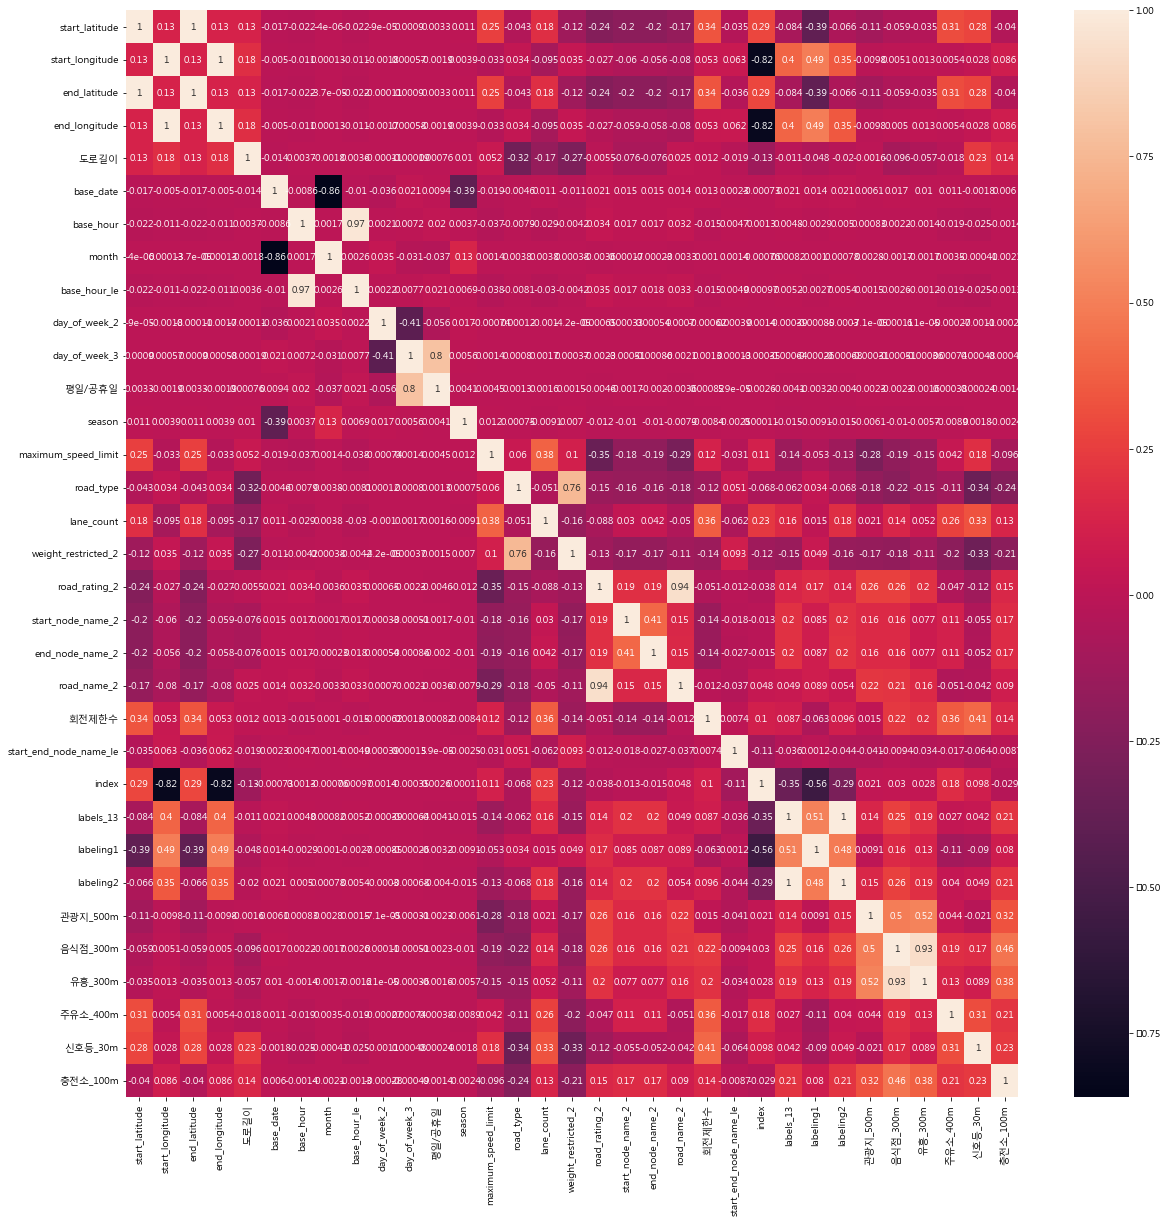

In [56]:
corr = df_train.corr()

plt.rcParams['figure.figsize'] = [20, 20]
sns.heatmap(corr, annot= True)

# 최종 데이터셋 : 상관관계가 높은 변수들이 있지만 트리기반 회귀모델이기 때문에 다중공선성 영향이 적다. 

In [57]:
# 전체 데이터로 학습 진행
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error as MAE

model = ExtraTreesRegressor(n_estimators=200 , n_jobs = 5, min_samples_split=10,
                            min_samples_leaf=10, random_state=10, verbose=2)

model.fit(df_train, Y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 200building tree 2 of 200
building tree 3 of 200building tree 4 of 200
building tree 5 of 200


building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  7.8min


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 34.0min


building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200


[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed: 44.6min finished


ExtraTreesRegressor(min_samples_leaf=10, min_samples_split=10, n_estimators=200,
                    n_jobs=5, random_state=10, verbose=2)

In [58]:
pd.DataFrame(model.feature_importances_, index=df_train.columns).sort_values(0, ascending=False)

,0
음식점_300m,0.156134
maximum_speed_limit,0.153095
road_rating_2,0.068561
labeling2,0.047774
index,0.045582
base_hour_le,0.041637
base_hour,0.038230
labels_13,0.036529
lane_count,0.032450
end_node_name_2,0.030880


* 외부 데이터로 만든 '음식점 300m' 변수가 가장 높은 변수 중요도를 보임

 
* 중요도가 높은 변수 : 도로별 제한 속도, 시간, 공간 데이터 (음식점_300m, maximum_speed_limit	, road_rating_2 등)

 
* 중요도가 낮은 변수 : 날짜, 요일 관련 데이터 (평일/공휴일, month, season, day_of_week_2 등)

In [59]:
sample_submission = pd.read_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/sample_submission.csv')
predict = model.predict(df_test)
sample_submission['target'] = predict
sample_submission.to_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/predict_etr_.csv', index=False)
sample_submission

# 제출 점수 MAE -> 3.112

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    6.6s finished


,id,target
0,TEST_000000,25.685755
1,TEST_000001,42.161233
2,TEST_000002,67.893817
3,TEST_000003,37.846476
4,TEST_000004,43.332856
...,...,...
291236,TEST_291236,46.831301
291237,TEST_291237,50.966940
291238,TEST_291238,21.545345
291239,TEST_291239,21.580987


In [60]:
# 후처리 : 반올림 시 점수가 더 올라감
import numpy as np
sample_submission['target'] = np.round(predict)
sample_submission.to_csv('/Users/EUNJI/Desktop/dacon/제주도교통량예측대회/predict_etr_round.csv', index=False)
sample_submission

# 최종 점수
# MAE -> 3.100

,id,target
0,TEST_000000,26.0
1,TEST_000001,42.0
2,TEST_000002,68.0
3,TEST_000003,38.0
4,TEST_000004,43.0
...,...,...
291236,TEST_291236,47.0
291237,TEST_291237,51.0
291238,TEST_291238,22.0
291239,TEST_291239,22.0
